Music Genre Classification Using CNN Networks
==============================================

We explore music genre classification by use of the GTZAN [(Tzanetakis et al., 2001)](http://ismir2001.ismir.net/pdf/tzanetakis.pdf) dataset, which contains 1000 songs, labeled with 10 genres:
   + Blues
   + Classical
   + Country
   + Disco
   + Hiphop
   + Jazz
   + Metal
   + Pop
   + Reggae
   + Rock
    
We do this by transforming the audio clips into spectrograms as per [(Costa et al., 2011)](http://www.ppgia.pucpr.br/~alekoe/Papers/ALEKOE-IWSSIP2011.pdf), and running them through CNNs. We use two CNNs here; a relatively shallow CNN of my design for a baseline, and a slightly modified VGG-16 [(Simonyan et al., 2015)](https://arxiv.org/pdf/1409.1556.pdf).

In [54]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, models
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, MaxPooling2D, BatchNormalization, Dropout

import pandas as pd
import numpy as np

import os
import librosa
import IPython.display as ipd
from scipy.io import wavfile

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.image as img

import gc

base_path = "/tensorflow_datasets/gtzan/"
## Get the inital data from Tensorflow Datasets.
gtzan = tfds.load('gtzan', split='train', data_dir = (os.getcwd() + base_path), shuffle_files = True)

assert isinstance(gtzan, tf.data.Dataset)

## Spectogram Functions

Below we create several helper functions to load, create and show spectograms, from the audio files saved in our path from the instructions above. Note that we had to manually clear the garbage as part of our pipeline.

In [2]:
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

def get_path(label: int, name: str):
    """
    Gets the audio path for file name of genre[label]
    @param label: the numerical genre for the song.
    @param name: the name of the file.
    @return: a string of where to find a file.
    """
    
    base = "tensorflow_datasets/gtzan/downloads/extracted/TAR_GZ.opihi.cs.uvic.ca_sound_genressVaJ63S5k9tFePACv2hfb_zFyG-LbSpfj1ST9JyBMts.tar.gz/genres/"
    return base + genres[label] + "/" + name

def show_spec(label: int, file_name: str):
    """
    Trys to read the spectogram for the file and genre. If it cannot find one, it creates it. Then pressents the spectogram.
    @param label: the numerical genre for the song.
    @param name: the name of the file.
    """
    
    try: 
        f = img.imread(os.getcwd() + base_path + "data/" + genres[label] + "/" + file_name + ".png")
        plt.imshow(f)
        plt.show()
    except:
        save_spec(label, path)
        f = img.imread(os.getcwd() + base_path + "data/" + genres[label] + "/" + file_name + ".png")
        plt.imshow(f)
        plt.show()
    
def return_spec(labe: int, file_name: str):
    """
    Trys to read the spectogram for the file and genre. If it cannot find one, it creates it. Then returns the spectogram.
    @param label: the numerical genre for the song.
    @param file_name: the name of the file.
    @return: returns the spectogram file.
    """
    try: 
        f = img.imread(os.getcwd() + base_path + "data/" + genres[label] + "/" + file_name + ".png")
        return f
    except:
        save_spec(path)
        f = img.imread(os.getcwd() + base_path + "data/" + genres[label] + "/" + file_name + ".png")
        return f
    
def save_spec(label: int, file_name: str):
    """
    Checks to see if the file_name already has a spectogram created for it. If so, return, if not then we build a spectogram
    and save it.
    @param label: the numerical genre for the song.
    @param name: the name of the file.
    """
    if not os.path.isfile(os.getcwd() + base_path + "data/" + genres[label] + "/" + file_name + ".png"):
        x, sr = librosa.load(path, sr=22050)
        X = librosa.stft(x)
        Xdb = librosa.amplitude_to_db(abs(X))
        fig = plt.figure(figsize=(14, 5))
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar()
        fig.savefig(os.getcwd() + base_path + "/data/" + genres[label] + "/" + file_name + ".png", bbox_inches='tight')
        fig.clf()
        # Clear the current axes.
        plt.cla() 
        # Clear the current figure.
        plt.clf() 
        # Closes all the figure windows.
        plt.close('all')   
        plt.close(fig)
        del fig
        gc.collect()

Next we save each audio file in our directory as a spectogram. This code is commented out generally to avoid accidentally running it.

In [ ]:
#for song in gtzan:
    #path = get_path(song["label"], tf.get_static_value(song["audio/filename"]).decode())
    #save_spec(tf.get_static_value(song["audio/filename"]).decode())
    #gc.collect()

## Exploratory

We take a small subset of the dataset, and display the genre, spectogram and play the music.

<TakeDataset shapes: {audio: (None,), audio/filename: (), label: ()}, types: {audio: tf.int64, audio/filename: tf.string, label: tf.int64}>


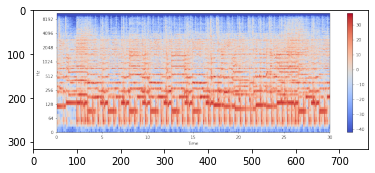

Label:  rock


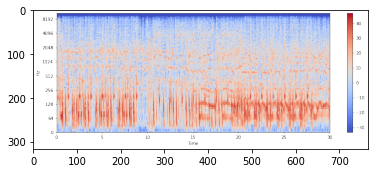

Label:  hiphop


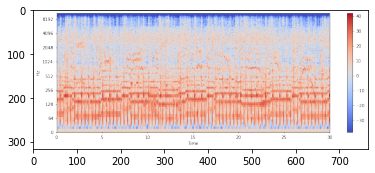

Label:  metal


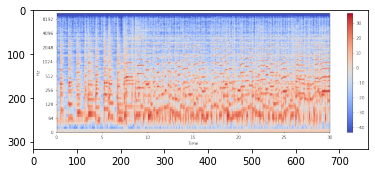

Label:  jazz


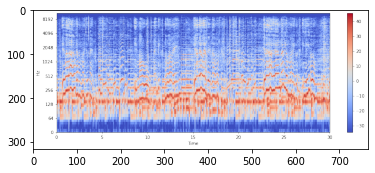

Label:  blues


In [3]:
# Load data from disk as tf.data.Datasets
ds = gtzan.take(5)
print(ds)
for song in ds:
    name = tf.get_static_value(song["audio/filename"]).decode()
    path = get_path(song["label"], name)
    ipd.display(ipd.Audio(path))
    
    show_spec(song["label"], name)
   
    print("Label: ", genres[tf.get_static_value(song["label"])])
    

## Preprocessing

Here we create our new dataset from the saved spectogram pngs using Kera's preprocessing functions. This will be the data that we eventually run our models with. Note also that here we have reduced the batch size and image size such that we do not run out of memory when running the model on it.

We then create a function that splits this dataset for us, which we proceed to do with a split of 80\:14\:6 for trainning\:test\:validation data.

In [4]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./tensorflow_datasets/gtzan/data/",
    #labels = labels,
    label_mode="int",
    #class_names=None,
    batch_size=8,
    image_size=(383, 108),
    shuffle=True
)

print(ds)

Found 1000 files belonging to 10 classes.
<BatchDataset shapes: ((None, 383, 108, 3), (None,)), types: (tf.float32, tf.int32)>


In [30]:
def split_dataset(dataset: tf.data.Dataset, validation_data_fraction: float):
    """
    Splits a dataset of type tf.data.Dataset into a training and validation dataset using given ratio. Fractions are
    rounded up to two decimal places.
    @param dataset: the input dataset to split.
    @param validation_data_fraction: the fraction of the validation data as a float between 0 and 1.
    @return: a tuple of two tf.data.Datasets as (training, validation)
    """

    validation_data_percent = round(validation_data_fraction * 100)
    if not (0 <= validation_data_percent <= 100):
        raise ValueError("validation data fraction must be ∈ [0,1]")

    dataset = dataset.enumerate()
    train_dataset = dataset.filter(lambda f, data: f % 100 > validation_data_percent)
    validation_dataset = dataset.filter(lambda f, data: f % 100 <= validation_data_percent)

    # remove enumeration
    train_dataset = train_dataset.map(lambda f, data: data)
    validation_dataset = validation_dataset.map(lambda f, data: data)

    return train_dataset, validation_dataset

train, test = split_dataset(ds, 0.2)
test, validation = split_dataset(test, 0.3)


print(train)
print(test)

<MapDataset shapes: ((None, 383, 108, 3), (None,)), types: (tf.float32, tf.int32)>
<MapDataset shapes: ((None, 383, 108, 3), (None,)), types: (tf.float32, tf.int32)>


## Models

We will attempt to learn this problem using two models, a simple, relatively shallow CNN of my design, and the classic VGG-16 model, so that we can compare speed of learning and accuracy, and make judgements on the tradeoffs.

Note that there was a particular difficult getting either model to learn the dataset at the default learning rate of 0.001 as it appeared to get stuck in a local minima.

Note also we have set up both models to run for 100 epochs, but with early stopping enabled.

### Simple

The simple model below has only about 5 million variables to calculate, and does so reasonably fast, in about 42 minutes, and with a validation accuracy of 0.83, an excellent accuracy for a small dataset such as this, and in a category that even humans have difficulty (i.e. is it rock? country? blues?)

In [34]:
simple = tf.keras.Sequential()
simple.add(Conv2D(32 , (3,3) ,activation = 'relu', input_shape=(383, 108, 3)))
simple.add(MaxPooling2D((3,3),strides=(2,2),padding='same'))
simple.add(BatchNormalization())

simple.add(Conv2D(64 , (3,3) ,activation = 'relu'))
simple.add(MaxPooling2D((3,3),strides=(2,2),padding='same'))
simple.add(BatchNormalization())
    
simple.add(Conv2D(128 , (2,2) ,activation = 'relu'))
simple.add(MaxPooling2D((2,2),strides=(2,2),padding='same'))
simple.add(BatchNormalization())
    
simple.add(Flatten())
simple.add(Dense(64,activation = 'relu'))
simple.add(Dropout(0.3))
simple.add(Dense(10,activation='softmax'))

simple.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 381, 106, 32)      896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 191, 53, 32)       0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 191, 53, 32)       128       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 189, 51, 64)       18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 95, 26, 64)        0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 95, 26, 64)        256       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 94, 25, 128)     

Epoch 1/100
83/83 [==============================] - 41s 491ms/step - loss: 2.5970 - accuracy: 0.1747 - val_loss: 2.2849 - val_accuracy: 0.1591
Epoch 2/100
83/83 [==============================] - 41s 489ms/step - loss: 2.1279 - accuracy: 0.1732 - val_loss: 2.1911 - val_accuracy: 0.1364
Epoch 3/100
83/83 [==============================] - 41s 489ms/step - loss: 2.0911 - accuracy: 0.2440 - val_loss: 2.2327 - val_accuracy: 0.1818
Epoch 4/100
83/83 [==============================] - 42s 503ms/step - loss: 2.0112 - accuracy: 0.2756 - val_loss: 1.9855 - val_accuracy: 0.2273
Epoch 5/100
83/83 [==============================] - 43s 513ms/step - loss: 2.0770 - accuracy: 0.2937 - val_loss: 1.9960 - val_accuracy: 0.2500
Epoch 6/100
83/83 [==============================] - 40s 479ms/step - loss: 1.9816 - accuracy: 0.2937 - val_loss: 1.8452 - val_accuracy: 0.3295
Epoch 7/100
83/83 [==============================] - 40s 478ms/step - loss: 1.8578 - accuracy: 0.3268 - val_loss: 1.9636 - val_accuracy:

83/83 [==============================] - 37s 446ms/step - loss: 0.7058 - accuracy: 0.7274 - val_loss: 0.6820 - val_accuracy: 0.7727
Epoch 58/100
83/83 [==============================] - 37s 445ms/step - loss: 0.6309 - accuracy: 0.7395 - val_loss: 0.4528 - val_accuracy: 0.9091
Epoch 59/100
83/83 [==============================] - 37s 451ms/step - loss: 0.6456 - accuracy: 0.7319 - val_loss: 0.3628 - val_accuracy: 0.9205
Epoch 60/100
83/83 [==============================] - 37s 446ms/step - loss: 0.6373 - accuracy: 0.7395 - val_loss: 0.4407 - val_accuracy: 0.8864
Epoch 61/100
83/83 [==============================] - 38s 459ms/step - loss: 0.6773 - accuracy: 0.7199 - val_loss: 0.4728 - val_accuracy: 0.8750
Epoch 62/100
83/83 [==============================] - 37s 448ms/step - loss: 0.6381 - accuracy: 0.7470 - val_loss: 0.3840 - val_accuracy: 0.8864
Epoch 63/100
83/83 [==============================] - 37s 445ms/step - loss: 0.6822 - accuracy: 0.7184 - val_loss: 0.4323 - val_accuracy: 0.886

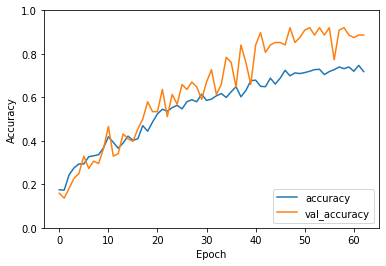

31/31 - 7s - loss: 0.6244 - accuracy: 0.8306
0.8306451439857483


In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0001)

simple.compile(optimizer = optimizer ,loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

history = simple.fit(train, 
                    epochs = 100, 
                    callbacks = [callback],
                    validation_data = test)


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

val_loss, val_acc = simple.evaluate(validation, verbose=2)
print(val_acc)

### VGG-16

Next we create and test the data on the VGG-16 model, which is a much deeper network than the simple one above, with 313,868,618 trainable variables. This takes just short of 6hrs (on my machine), nearly 7 times longer, but it does yield a much more accurate model, with a validation accuracy of 0.90.

In [29]:
## VGG-16 Model
vgg = tf.keras.Sequential()
vgg.add(Conv2D(input_shape=(383,108,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

vgg.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

vgg.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

vgg.add(Conv2D(filters=64 kernel_size=(3,3), padding="same", activation="relu"))
vgg.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
vgg.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
vgg.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

vgg.add(Flatten())
vgg.add(Dense(units=4096,activation="relu"))
vgg.add(Dense(units=4096,activation="relu"))
vgg.add(Dense(units=10, activation="softmax"))

vgg.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 383, 108, 64)      1792      
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 383, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 191, 54, 64)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 191, 54, 128)      73856     
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 191, 54, 128)      147584    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 95, 27, 128)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 95, 27, 256)     

Epoch 1/100
83/83 [==============================] - 576s 7s/step - loss: 2.8545 - accuracy: 0.1717 - val_loss: 1.9980 - val_accuracy: 0.2727
Epoch 2/100
83/83 [==============================] - 490s 6s/step - loss: 1.9777 - accuracy: 0.2726 - val_loss: 1.9593 - val_accuracy: 0.2386
Epoch 3/100
83/83 [==============================] - 499s 6s/step - loss: 1.7863 - accuracy: 0.3419 - val_loss: 1.7303 - val_accuracy: 0.3864
Epoch 4/100
83/83 [==============================] - 486s 6s/step - loss: 1.6512 - accuracy: 0.3916 - val_loss: 1.5351 - val_accuracy: 0.4318
Epoch 5/100
83/83 [==============================] - 483s 6s/step - loss: 1.4632 - accuracy: 0.4563 - val_loss: 1.5394 - val_accuracy: 0.4318
Epoch 6/100
83/83 [==============================] - 498s 6s/step - loss: 1.3725 - accuracy: 0.4849 - val_loss: 1.5227 - val_accuracy: 0.4091
Epoch 7/100
83/83 [==============================] - 485s 6s/step - loss: 1.2028 - accuracy: 0.5768 - val_loss: 1.4713 - val_accuracy: 0.4659
Epoch 

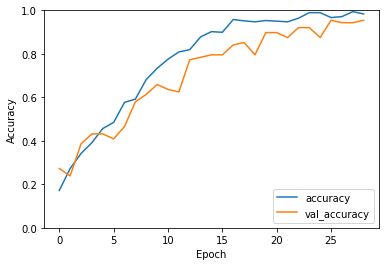

31/31 - 31s - loss: 0.5206 - accuracy: 0.8952
0.8951612710952759


In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0001)

vgg.compile(optimizer = optimizer ,loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

history = vgg.fit(train,
                  epochs = 100, 
                  callbacks = [callback],
                  validation_data = test)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

val_loss, val_acc = vgg.evaluate(validation, verbose=2)
print(val_acc)

In [33]:
## For general clean up.
gc.collect()

49273

## Conclusion

To conclude we have successfully built not one, but two models capable of music genre identification, by building on the strengths of CNN's image processing. The VGG-16 model is undeniable a more accurate model at a success rate of 90% to 83%, but takes much longer to train, and in an area were genres can be very loosly defined and even humans can disagree, this trade off may not be worth it in larger models.

Improvements can be made in the form of a pipeline for testing your own audio, pre-training the model, and using a larger set, for example, the million songs dataset found [here](http://millionsongdataset.com/).

## Appendix
### Confusion Matrices

Both our models are fairly accurate, but lets see where exactly they mess up when they do, and if it is in expected areas.

This wasn't included as I'm not sure how to get these reading the way I've expected them to in the past.

In [65]:
import plotly.figure_factory as ff
#Confution Matrix and Classification Report
def plot_confusion(labels, validation_dataset, model, title):
    ## Compute predicted labels
    Y_pred = model.predict(validation_dataset, verbose = 2)
    y_pred = np.argmax(Y_pred, axis=1)

    ## Get Real labels
    validation_labels = tf.concat([y for x, y in validation_dataset], axis=0)

    ## Compute confusion matrix
    cm = confusion_matrix(validation_labels, y_pred)

    cm_text = [[str(round(y/len(validation_labels), 2)) for y in x] for x in cm]

    fig = ff.create_annotated_heatmap(cm, x=labels, y=labels[::-1].copy(), annotation_text=cm_text, colorscale='Viridis')
    fig.update_layout(title_text='<i><b>' + title + '</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

    fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

    fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

    fig.update_layout(margin=dict(t=50, l=200))
    fig['data'][0]['showscale'] = True
    fig.show()